
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:200%;
            text-align:center;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">Taxi fare prediction</div>

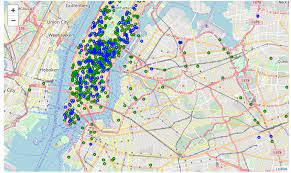![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ6NwlhKAjIahuIRHJEmCmc5-oKL3NTiCGmCw&usqp=CAU)  

<a id="toc"></a>
- [1 Import Libraries](#1)
- [2 Import Data](#2)
- [3 Data demonstration](#3)
- [4 Data preprocessing](#4)
- [5 Model building with machine learning](#5)
- [6 Conclusion](#6)

<a id="1"></a>
## <b>1 <span style='color:red;background-color:#294B8E;margin:10;font-size:200%' >Import Libraries</span></b> 

In [ ]:
import numpy as np 
import pandas as pd
import scipy as scipy
import datetime as dt
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
import os
import gc
import seaborn as sns
import matplotlib.pyplot as plt

<a id="2"></a>
## <b>2 <span style='color:red;background-color:#294B8E;margin:10;font-size:200%' >Import Data</span></b> 


<div style=" background-color:#3b3745;text-align:left; padding: 13px 13px; border-radius: 8px; color: white">
<ul>The data for this project can be found on Kaggle in the New York City Taxi Fare Prediction competition held by Google Cloud. The entire training set consists of about 55 million rows of NYC taxi fare data.
</ul>
</div>

In [ ]:
train=pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/train.csv',nrows = 500000)
test=pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/test.csv')
sample=pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv')

<a id="3"></a>
## <b>3 <span style='color:red;background-color:#294B8E;margin:10;font-size:200%' >Data  Demonstration</span></b> 

In [ ]:
train

In [ ]:
test

In [ ]:
sample

In [ ]:
train.describe()


## <b> <span style='color:red;background-color:#294B8E;margin:10;font-size:200%' >EDA</span></b>

In [ ]:
sns.scatterplot(x='pickup_longitude', y= 'pickup_latitude', hue='fare_amount',data=train)
plt.show()

In [ ]:
sns.scatterplot(x='dropoff_longitude', y= 'dropoff_latitude',hue='fare_amount',data=train)
plt.show()

In [ ]:
sns.scatterplot(x='pickup_longitude', y= 'pickup_latitude', data=train )
plt.show()

In [ ]:
train.hist(figsize=(22,21), bins=20);

<a id="4"></a>
## <b>4 <span style='color:red;background-color:#294B8E;margin:10;font-size:200%' >Data preprocessing</span></b> 

In [ ]:
train.isnull().sum()

There appears to be an insignificant amount of null entries in the sample so it should be fine to remove them from the sample

In [ ]:
#Drop rows with null values
train = train.dropna(how = 'any', axis = 'rows')

In [ ]:
def clean_df(df):
    return df[(df.fare_amount > 0)  & (df.fare_amount <= 500) &
          # (df.passenger_count >= 0) & (df.passenger_count <= 8)  &
           ((df.pickup_longitude != 0) & (df.pickup_latitude != 0) & (df.dropoff_longitude != 0) & (df.dropoff_latitude != 0) )]

train = clean_df(train)


# To compute Haversine distance

In [ ]:
def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    #Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    return 2 * R_earth * np.arcsin(np.sqrt(a))


In [ ]:
def sphere_dist_bear(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = pickup_lon - dropoff_lon
    
    #Compute bearing distance
    a = np.arctan2(np.sin(dlon * np.cos(dropoff_lat)),np.cos(pickup_lat) * np.sin(dropoff_lat) - np.sin(pickup_lat) * np.cos(dropoff_lat) * np.cos(dlon))
    return a

In [ ]:
def radian_conv(degree):
    return  np.radians(degree)    

def add_airport_dist(dataset):
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    sol_coord = (40.6892,-74.0445) # Statue of Liberty
    nyc_coord = (40.7141667,-74.0063889) 
    
    
    pickup_lat = dataset['pickup_latitude']
    dropoff_lat = dataset['dropoff_latitude']
    pickup_lon = dataset['pickup_longitude']
    dropoff_lon = dataset['dropoff_longitude']
    
    pickup_jfk = sphere_dist(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = sphere_dist(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = sphere_dist(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = sphere_dist(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = sphere_dist(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = sphere_dist(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon)
    pickup_sol = sphere_dist(pickup_lat, pickup_lon, sol_coord[0], sol_coord[1]) 
    dropoff_sol = sphere_dist(sol_coord[0], sol_coord[1], dropoff_lat, dropoff_lon)
    pickup_nyc = sphere_dist(pickup_lat, pickup_lon, nyc_coord[0], nyc_coord[1]) 
    dropoff_nyc = sphere_dist(nyc_coord[0], nyc_coord[1], dropoff_lat, dropoff_lon)
    
    
    
    dataset['jfk_dist'] = pickup_jfk + dropoff_jfk
    dataset['ewr_dist'] = pickup_ewr + dropoff_ewr
    dataset['lga_dist'] = pickup_lga + dropoff_lga
    dataset['sol_dist'] = pickup_sol + dropoff_sol
    dataset['nyc_dist'] = pickup_nyc + dropoff_nyc
    
    return dataset

 
<div style=" background-color:#3b3745;text-align:left; padding: 13px 13px; border-radius: 8px; color: white">
<ul>Return minumum distance from pickup or dropoff coordinates to each airport.
<li>JFK: John F. Kennedy International Airport
<li>EWR: Newark Liberty International Airport
<li>LGA: LaGuardia Airport
<li>SOL: Statue of Liberty 
<li>NYC: Newyork Central
</ul>
</div>

# Convert to datetime format

<div style=" background-color:#3b3745;text-align:left; padding: 13px 13px; border-radius: 8px; color: white">
<ul>In order for object types to be utilized in our machine learning model, the feature needs to be transformed into a numeric type. This can be accomplished by converting the feature to a datetime type and then transforming the datetime object into multiple attributes using the Pandas datetime functionality. From the datetime object, we’ll be able to create useful attributes like Year, Month, Day, Day of Week, and Hour
</ul>
</div>

In [ ]:
def add_datetime_info(dataset):
    dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")
    
    dataset['hour'] = dataset.pickup_datetime.dt.hour
    dataset['day'] = dataset.pickup_datetime.dt.day
    dataset['month'] = dataset.pickup_datetime.dt.month
    dataset['weekday'] = dataset.pickup_datetime.dt.weekday
    dataset['year'] = dataset.pickup_datetime.dt.year
    
    return dataset


<div style=" background-color:#3b3745;text-align:left; padding: 13px 13px; border-radius: 8px; color: white">
<ul>The city of New York longitude ranges between -75 and -72. The latitude ranges between 40 and 42. There are a few points in the dataset that lie outside these bounds. These points will be removed since they are not within the boundaries of the city.
</ul>
</div>

In [ ]:
train = add_datetime_info(train)
train = add_airport_dist(train)
train['distance'] = sphere_dist(train['pickup_latitude'], train['pickup_longitude'], 
                                   train['dropoff_latitude'] , train['dropoff_longitude']) 

train['bearing'] = sphere_dist_bear(train['pickup_latitude'], train['pickup_longitude'], 
                                   train['dropoff_latitude'] , train['dropoff_longitude'])                                    
train['pickup_latitude'] = radian_conv(train['pickup_latitude'])
train['pickup_longitude'] = radian_conv(train['pickup_longitude'])
train['dropoff_latitude'] = radian_conv(train['dropoff_latitude'])
train['dropoff_longitude'] = radian_conv(train['dropoff_longitude'])


train.drop(columns=['key', 'pickup_datetime'], inplace=True)

y = train['fare_amount']
train = train.drop(columns=['fare_amount'])


train.head()


In [ ]:
test = add_datetime_info(test)
test = add_airport_dist(test)
test['distance'] = sphere_dist(test['pickup_latitude'], test['pickup_longitude'], 
                                   test['dropoff_latitude'] , test['dropoff_longitude'])

test['bearing'] = sphere_dist_bear(test['pickup_latitude'], test['pickup_longitude'], 
                                    test['dropoff_latitude'] , test['dropoff_longitude'])  
test['pickup_latitude'] = radian_conv(test['pickup_latitude'])
test['pickup_longitude'] = radian_conv(test['pickup_longitude'])
test['dropoff_latitude'] = radian_conv(test['dropoff_latitude'])
test['dropoff_longitude'] = radian_conv(test['dropoff_longitude'])
                                                                    


test_key = test['key']
test= test.drop(columns=['key', 'pickup_datetime'])

<a id="5"></a>
 <b>5 <span style='color:red;background-color:#294B8E;margin:10;font-size:200%' >Model building with Machine learning</span></b>

<div style=" background-color:#3b3745;text-align:left; padding: 13px 13px; border-radius: 8px; color: white">
<ul>Now that we have a clean dataset, we are ready to train a model for predicting taxi fare. Before we do that through, we will split the dataset into a train (90%) and test (10%).
</ul>
</div>


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(train,y,random_state=123,test_size=0.10)

del train
del y
gc.collect()

params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000
    }
    
train_set = lgbm.Dataset(x_train, y_train, silent=False,categorical_feature=['year','month','day','weekday'])
valid_set = lgbm.Dataset(x_test, y_test, silent=False,categorical_feature=['year','month','day','weekday'])
model = lgbm.train(params, train_set = train_set, num_boost_round=10000,early_stopping_rounds=500,verbose_eval=500, valid_sets=valid_set)

# Predict from test set

In [ ]:
prediction = model.predict(test, num_iteration = model.best_iteration)      
submission = pd.DataFrame({
        "key": test_key,
        "fare_amount": prediction
})

submission.to_csv('submission.csv',index=False)

<a id="6"></a>
 <b>6 <span style='color:red;background-color:#294B8E;margin:10;font-size:200%' >Conslusion</span></b>


<div style=" background-color:#3b3745;text-align:left; padding: 13px 13px; border-radius: 8px; color: white">

<ul> Why is taxi fare prediction important?
    
The main objective is to estimate travel costs before booking a cab to have transparency and avoid unfair practices. Our system is designed to allow individuals to estimate taxi trip fares by using various dynamic conditions such as weather, cab availability, cab size, and the distance between two locations.
</ul>
</div>